# Culvert Design using FHWA HDS5: Inlet Control

In this notebook, we'll compare a performance curve with both Inlet and Outlet Controls.

## HY-8

The model is saved to : **./data/hds5_example.hy8**

The main difference I made is to lower the inlet elevation from 100 to 98.5ft. So the slope changed from 0.01ft/ft to 0.0025ft/ft.







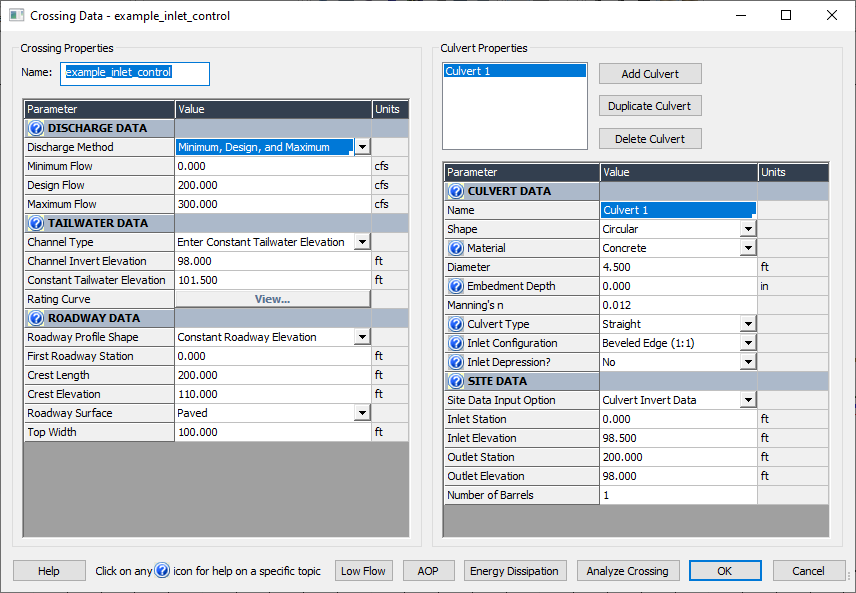

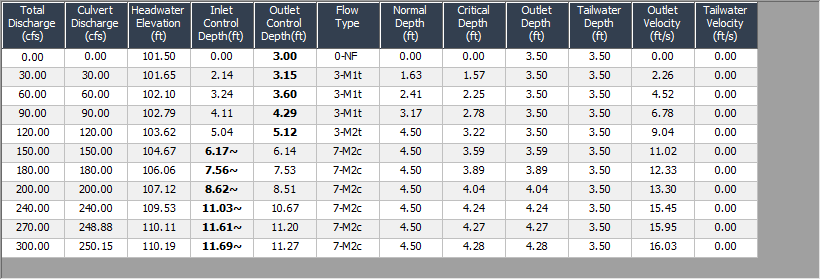

# Performance Curve

HY8 gives the performance curve for the culvert. The table is saved to **./data/hy8_performance_curve2.csv**

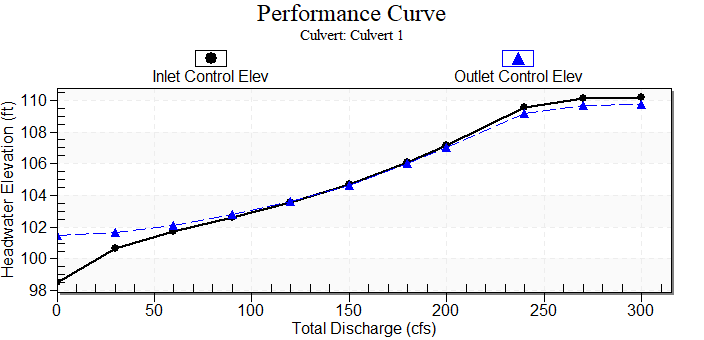

The same data is plotted from the csv file below.

C:\Users\Mel.Meng\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


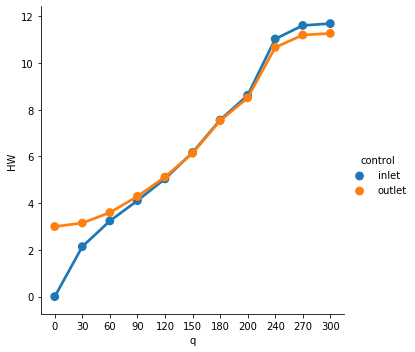

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

f = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\culvert\data\hy8_performance_curve2.csv"

df = pd.read_csv(f)
df_hy8_melt = df.melt('q', var_name='control',  value_name='HW')
g = sns.factorplot(x="q", y="HW", hue='control', data=df_hy8_melt)
plt.show()

## SWMM5 Model

A SWMM5 model is created to compare the performance curve.

Model: **./data/hds5_example2.inp**

SWMM5 gives an answer of 7.94 ft for headwater depth, within 10% to HY8 result of 8.62ft.



## Performance Curve : SWMM5 vs HY8

Using the code blocks below, I was able to compare the results.

In [1]:
from swmm.output import output as smo
import pandas as pd
import datetime
from pyswmm import Simulation, Subcatchments
import matplotlib.pyplot as plt
def run(inp_path):
    sim = Simulation(inp_path)
    sim.execute()
    

def swmm_dt(days):
    # convert swmm dates number to date
    # https://www.openswmm.org/Topic/4343/output-file-start-date-and-time-of-the-simulation
    t0 = pd.to_datetime('12/31/1899 00:00')
    t1 = t0 + datetime.timedelta(days=(days-1)) # I don't understand why I need to -1, hey it works. 
    return t1


def extract_node(out_path, node_index=0):
    # extract the rainfall results from *.out file
    handle = smo.init()
    smo.open(handle, out_path)

    # swmm out file report time using its only integer format, it needs to be converted to datetime
    report_start_date_time = smo.getstartdate(handle)
    start_dt = swmm_dt(report_start_date_time)

    # to build the timestamps, we'll need the number of reported steps, and the step length in seconds
    num_steps = smo.gettimes(handle, smo.Time.NUM_PERIODS)
    report_step = smo.gettimes(handle, smo.Time.REPORT_STEP)

    # build the date range
    timestep = pd.date_range(start=start_dt, periods=num_steps, freq='%smin' % (report_step/60.0))


    # Just want to confirm the subcatchments index 
    print(smo.getelementname(handle, smo.ElementType.NODE, 0))

    # get the time sereis from the out file
    depth = smo.getnodeseries(handle, node_index, smo.NodeAttribute.INVERT_DEPTH, 0, num_steps)
    q = smo.getnodeseries(handle, node_index, smo.NodeAttribute.TOTAL_INFLOW, 0, num_steps)
    df = pd.DataFrame({'swmm5': depth, 'q': q}, index=timestep)
    return df


In [2]:
f = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\culvert\data\hds5_example2.inp"
# run(f)
out_path = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\culvert\data\hds5_example2.out"
df_swmm = extract_node(out_path, 0)

54RCP_2


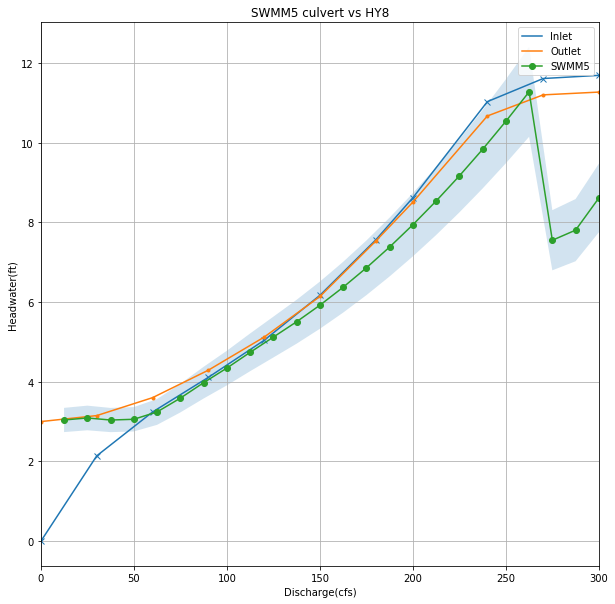

In [5]:

ax = df.plot(x='q', y='inlet', label='Inlet', style='x-', figsize=(10,10))
ax = df.plot(x='q', y='outlet', label='Outlet', style='.-', ax=ax)
ax = df_swmm.plot(x='q', y='swmm5', label='SWMM5', style='o-', ax=ax)
ax.fill_between(df_swmm['q'], df_swmm['swmm5']*0.9, df_swmm['swmm5']*1.1, alpha=0.2)
plt.xlabel('Discharge(cfs)')
plt.ylabel('Headwater(ft)')
plt.title('SWMM5 culvert vs HY8')
plt.grid(True)
plt.show()

The comparison is shown above,
- X is the discharge, Y is the head water depth
- the green line is swmm5 results
- the shaded area is the 90-110% for the swmm5 simulated curve
- the orange is the inlet curve
- the blue is the outlet curve

The conclusions,
- the culvert performance curve is the higher of the inlet/outlet curve
- SWMM5 correctly used the inlet control at very low flows, and correctly switched the outlet solutions
- For most part, SWMM5 results are within 10% of the HY8 results.
